In [1]:
!pip install tf-nightly

     |████████████████████████████████| 489.7 MB 24 kB/s 
     |████████████████████████████████| 12.8 MB 152 kB/s 
     |████████████████████████████████| 5.8 MB 28.8 MB/s 
     |████████████████████████████████| 2.1 MB 45.8 MB/s 
     |████████████████████████████████| 1.3 MB 67.0 MB/s 
     |████████████████████████████████| 463 kB 57.6 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires flatbuffers~=1.12.0, but you have flatbuffers 2.0 which is incompatible.


In [2]:
import tensorflow as tf 
tf.__version__

'2.8.0-dev20210930'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pwd

'/content'

In [5]:
cd /content/drive/My Drive

/content/drive/My Drive


In [6]:
%cd '/content/drive/My Drive/tf2/object_detection'

/content/drive/My Drive/tf2/object_detection


In [7]:
!pip install tf-models-official
!pip install tf_slim
!pip install lvis

     |████████████████████████████████| 1.8 MB 22.0 MB/s 
     |████████████████████████████████| 1.1 MB 40.9 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 4.4 MB 41.8 MB/s 
     |████████████████████████████████| 1.2 MB 44.7 MB/s 
     |████████████████████████████████| 99 kB 8.5 MB/s 
     |████████████████████████████████| 636 kB 42.9 MB/s 
     |████████████████████████████████| 213 kB 59.4 MB/s 
     |████████████████████████████████| 90 kB 10.1 MB/s 
     |████████████████████████████████| 37.1 MB 52 kB/s 
     |████████████████████████████████| 352 kB 73.6 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=34fc4731f6695c19ad84c3b87e2bbbb43ce06564b042eae6dd9c0dac68c9a903
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=f1e3061d24681b5d

In [8]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/My Drive/tf2/object_detection/efficientdet_d0_coco17_tpu-32/saved_model/',signature_keys=['serving_default'])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

Num GPUs Available:  0
Loading model...

Done! Took 38.354719400405884 seconds
Running inference for /content/drive/My Drive/tf2/object_detection/images/test/collagelunares.png... Done


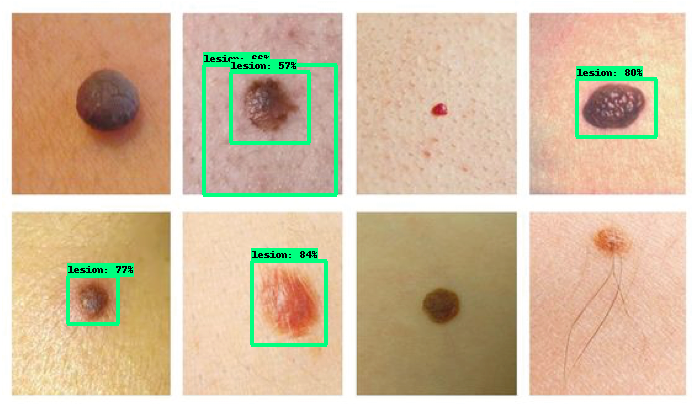

In [32]:
"""
Object Detection (On Image) From TF2 Saved Model
=====================================
"""

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
import cv2
import argparse
from google.colab.patches import cv2_imshow

# Enable GPU dynamic memory allocation
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    allow_growth = True
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
# PROVIDE PATH TO IMAGE DIRECTORY
IMAGE_PATHS = '/content/drive/My Drive/tf2/object_detection/images/test/collagelunares.png'


# PROVIDE PATH TO MODEL DIRECTORY
PATH_TO_MODEL_DIR = '/content/drive/My Drive/tf2/object_detection/inference_graph'

# PROVIDE PATH TO LABEL MAP
PATH_TO_LABELS = '/content/drive/My Drive/tf2/object_detection/images/label_map.pbtxt'

# PROVIDE THE MINIMUM CONFIDENCE THRESHOLD
MIN_CONF_THRESH = float(0.60)

# LOAD THE MODEL

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# LOAD SAVED MODEL AND BUILD DETECTION FUNCTION
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

# LOAD LABEL MAP DATA FOR PLOTTING

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.
    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.
    Args:
      path: the file path to the image
    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))




print('Running inference for {}... '.format(IMAGE_PATHS), end='')

image = cv2.imread(IMAGE_PATHS)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_expanded = np.expand_dims(image_rgb, axis=0)

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

# input_tensor = np.expand_dims(image_np, 0)
detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
               for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_with_detections = image.copy()

# SET MIN_SCORE_THRESH BASED ON YOU MINIMUM THRESHOLD FOR DETECTIONS
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=0.5,
      agnostic_mode=False)

print('Done')
# DISPLAYS OUTPUT IMAGE
cv2_imshow(image_with_detections)
# CLOSES WINDOW ONCE KEY IS PRESSED
